# CARE Denoising with the Tribolium Dataset

The Tribolium dataset is composed of noisy and GT high SNR images for training and testing. The dataset was acquired with fluorescence microscopy, originally used in Weigert et al (2018) to showcase CARE denoising.

In [6]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tifffile import imread
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from microssim import micro_structural_similarity

# Utility function for visualization
def visualize_images(img1, img2, title1="Low", title2="High", aspect='auto'):
    """
    Visualize two images side by side with consistent aspect ratio.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 10))
    ax[0].imshow(img1, aspect=aspect)
    ax[0].set_title(title1)
    ax[0].axis('off')
    
    ax[1].imshow(img2, aspect=aspect)
    ax[1].set_title(title2)
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()


## Load the training data

In [7]:
# Download and extract the dataset
import requests, zipfile, io

url = 'http://csbdeep.bioimagecomputing.com/example_data/tribolium.zip'

print("Downloading and extracting dataset...")
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('data')
print("Dataset successfully downloaded and extracted to 'data'.")

Dataset successfully downloaded and extracted to 'data'.


In [8]:
from tifffile import imread
from pathlib import Path

# Define paths to training and test data
train_low_path = Path('data/tribolium/train/low/nGFP_0.1_0.2_0.5_20_13_late.tif')
train_gt_path = Path('data/tribolium/train/GT/nGFP_0.1_0.2_0.5_20_13_late.tif')
test_low_path = Path('data/tribolium/test/low/nGFP_0.1_0.2_0.5_20_14_late.tif')
test_gt_path = Path('data/tribolium/test/GT/nGFP_0.1_0.2_0.5_20_14_late.tif')

# Load training and test images directly
train_low_sample = imread(train_low_path)
train_gt_sample = imread(train_gt_path)
test_low_sample = imread(test_low_path)
test_gt_sample = imread(test_gt_path)

print(f"\nTraining Data (Low SNR): Shape: {train_low_sample.shape}")
print(f"Training Data (Ground Truth): Shape: {train_gt_sample.shape}")
print(f"Test Data (Low SNR): Shape: {test_low_sample.shape}")
print(f"Test Data (Ground Truth): Shape: {test_gt_sample.shape}")

# Assign directly to X_images and Y_images
X_images = train_low_sample
Y_images = train_gt_sample


Training Data (Low SNR): Shape: (48, 773, 665)
Training Data (Ground Truth): Shape: (48, 773, 665)
Test Data (Low SNR): Shape: (45, 954, 486)
Test Data (Ground Truth): Shape: (45, 954, 486)


In [9]:
# Define paths to the low and ground truth images
low_snr_path = Path('data/tribolium/train/low')
gt_path = Path('data/tribolium/train/GT')
low_snr_files = sorted(low_snr_path.glob('*.tif'))
gt_files = sorted(gt_path.glob('*.tif'))

print(f"Found {len(low_snr_files)} training image pairs.")


Found 1 training image pairs.


## Visualize the training data

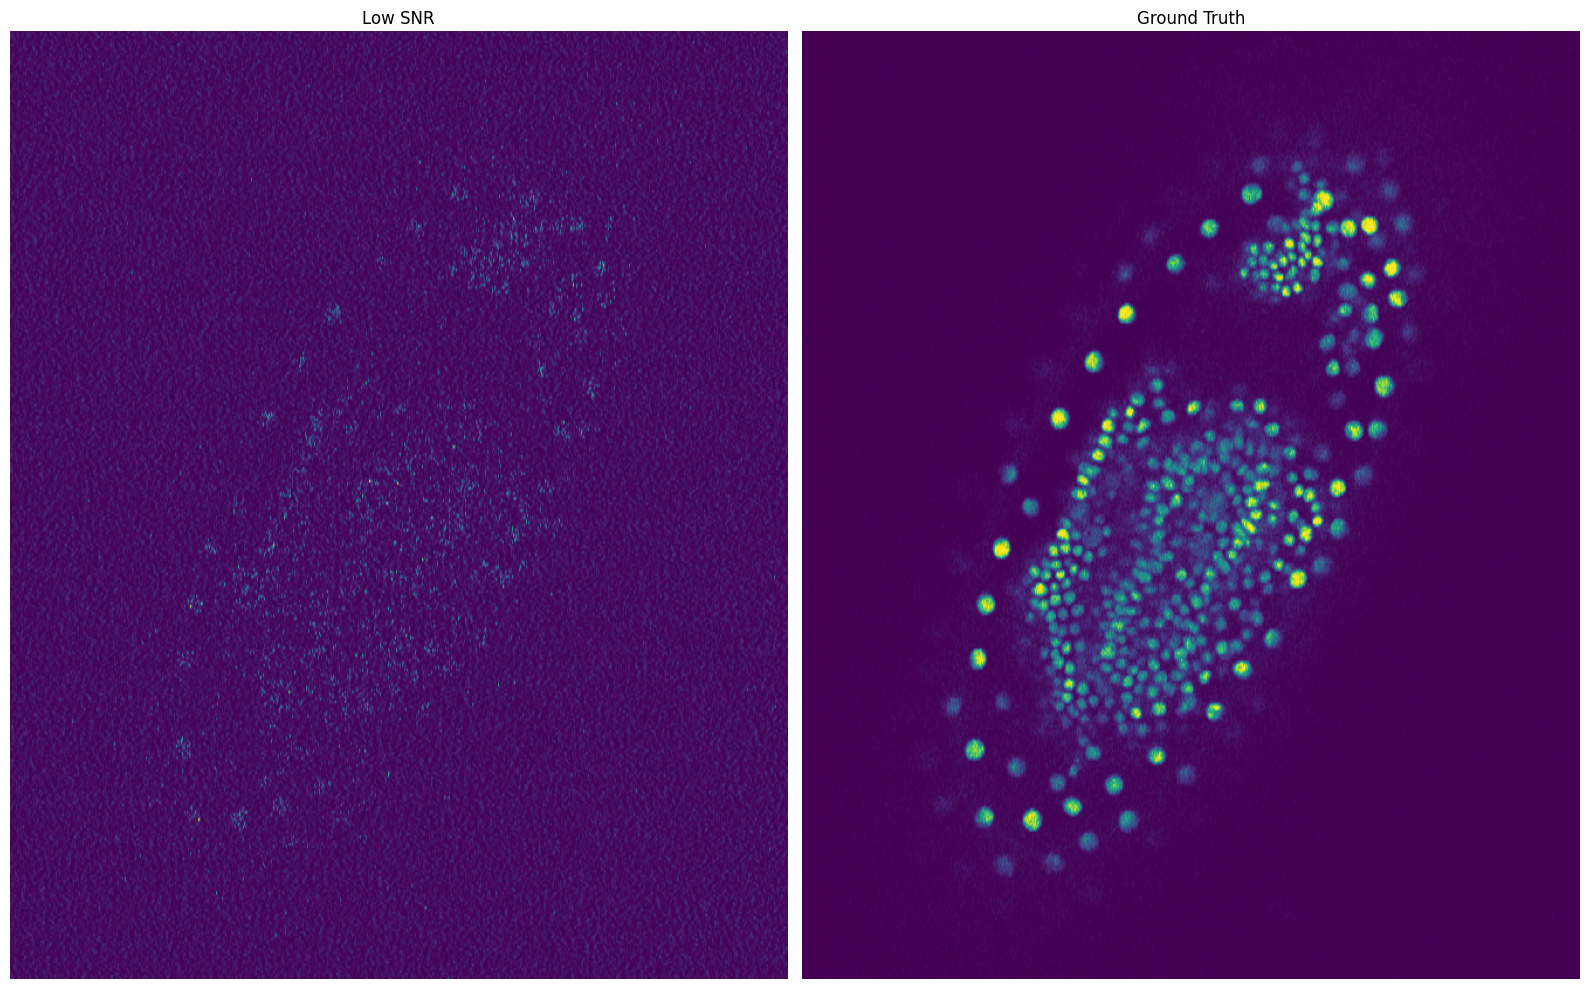

In [10]:
# Visualize a middle slice from the training data (3D ZYX)
slice_idx = X_images.shape[0] // 2 
low_img_slice = X_images[slice_idx, :, :] 
gt_img_slice = Y_images[slice_idx, :, :]  

# Visualize using the utility function
visualize_images(low_img_slice, gt_img_slice, title1="Low SNR", title2="Ground Truth")


## Configure CARE denoising model

In [13]:
# Create CARE configuration
config = create_care_configuration(
    experiment_name="CARE_Tribolium",
    data_type="array",
    axes="ZYX", 
    patch_size=(16, 64, 64), 
    batch_size=1,
    num_epochs=100,
    model_checkpoint={},  
)

## Initialize and train the model

In [14]:
careamist = CAREamist(config)
careamist.train(
    train_source=X_images,
    train_target=Y_images,
    val_percentage=0.05, 
    val_minimum_split=20, 
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/care/denoising/3D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 429 patches from input array.
Computed dataset mean: [7.94022998], std: [6.98370222]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.5 M  | train
---------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.094     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 408/408 [00:05<00:00, 78.61it/s, train_loss_step=0.0132, val_loss=0.166, train_loss_epoch=0.115]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 408/408 [00:05<00:00, 73.60it/s, train_loss_step=0.0132, val_loss=0.166, train_loss_epoch=0.115]


## Prediction with CAREamics

In [15]:
test_low_images = imread(test_low_path)
test_gt_images = imread(test_gt_path)

print(f"Test data shape: {test_low_images.shape} (ZYX)")

# Perform prediction with the test data
predictions = careamist.predict(
    source=test_low_images, 
    data_type="array",
    axes="ZYX", 
    tile_size=(16, 64, 64), 
    tile_overlap=(8, 32, 32), 
    batch_size=1, 
    tta=False
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test data shape: (45, 954, 486) (ZYX)


/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## Visualize Predictions vs Ground Truth

Test low images shape: (45, 954, 486) (ZYX)
Test GT images shape: (45, 954, 486) (ZYX)
Test predictions shape after squeezing: (45, 954, 486) (ZYX)


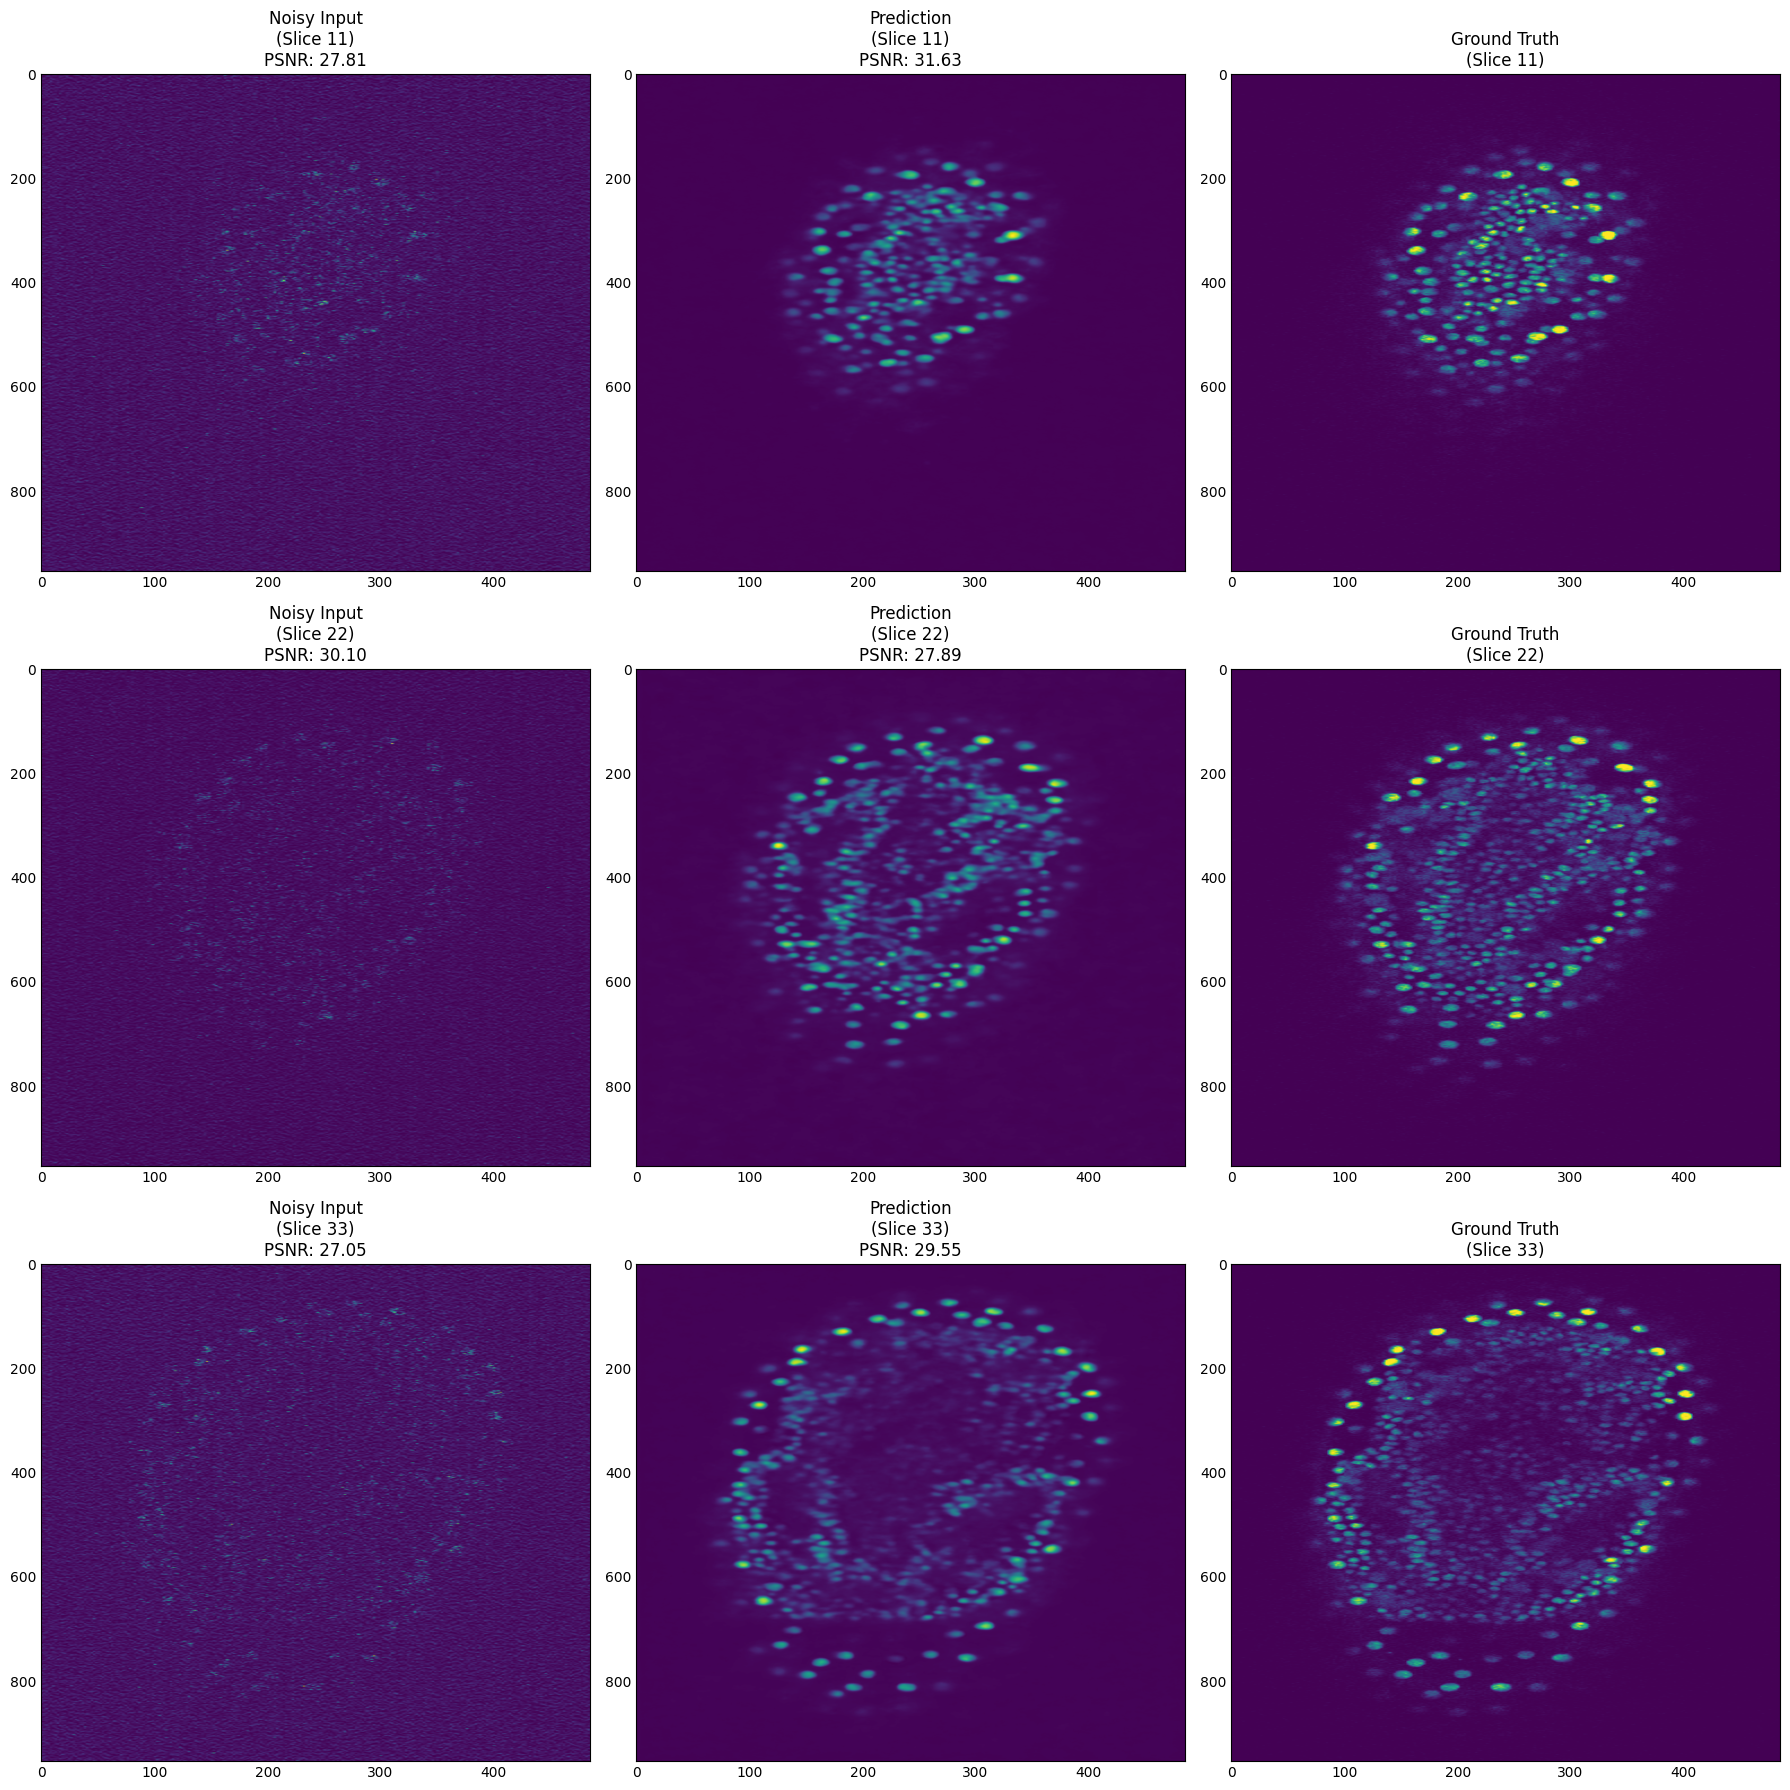

In [16]:
# Convert predictions to NumPy array and remove unnecessary dimensions
test_predictions = np.squeeze(np.array(predictions))

# Verify the shapes
print(f"Test low images shape: {test_low_images.shape} (ZYX)")
print(f"Test GT images shape: {test_gt_images.shape} (ZYX)")
print(f"Test predictions shape after squeezing: {test_predictions.shape} (ZYX)")

num_slices = test_low_images.shape[0]
slice_indices = [num_slices // 4, num_slices // 2, 3 * num_slices // 4]
fig, axes = plt.subplots(len(slice_indices), 3, figsize=(18, 6 * len(slice_indices)))

for row_idx, slice_idx in enumerate(slice_indices):
    # Extract slices
    noisy_slice = test_low_images[slice_idx].astype(np.float32)
    pred_slice = test_predictions[slice_idx].astype(np.float32)
    gt_slice = test_gt_images[slice_idx].astype(np.float32)

    # Compute PSNR
    psnr_noisy = scale_invariant_psnr(noisy_slice, gt_slice)
    psnr_pred = scale_invariant_psnr(pred_slice, gt_slice)

    # Plot slices
    for col_idx, (img, title) in enumerate([
        (noisy_slice, f"Noisy Input\n(Slice {slice_idx})\nPSNR: {psnr_noisy:.2f}"),
        (pred_slice, f"Prediction\n(Slice {slice_idx})\nPSNR: {psnr_pred:.2f}"),
        (gt_slice, f"Ground Truth\n(Slice {slice_idx})")
    ]):
        axes[row_idx, col_idx].imshow(img, aspect="auto")
        axes[row_idx, col_idx].set_title(title)
        axes[row_idx, col_idx].tick_params(axis="both", which="both", length=0) 

plt.tight_layout()
plt.show()


## Compute average PSNR and microSSIM over all slices

In [17]:
psnr_noisy_list = [
    scale_invariant_psnr(test_low_images[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_low_images.shape[0])
]

microssim_noisy_list = [
    micro_structural_similarity(test_low_images[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_low_images.shape[0])
]

# Compute PSNR and MicroSSIM for predictions across all slices
psnr_pred_list = [
    scale_invariant_psnr(test_predictions[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_predictions.shape[0])
]

microssim_pred_list = [
    micro_structural_similarity(test_predictions[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_predictions.shape[0])
]

# Calculate average values
average_psnr_noisy = np.mean(psnr_noisy_list)
average_psnr_pred = np.mean(psnr_pred_list)
average_microssim_noisy = np.mean(microssim_noisy_list)
average_microssim_pred = np.mean(microssim_pred_list)

# Print the results
print(f"Average PSNR of Noisy Input (Test Data): {average_psnr_noisy:.2f}")
print(f"Average PSNR of Prediction (Test Data): {average_psnr_pred:.2f}")
print(f"Average MicroSSIM of Noisy Input (Test Data): {average_microssim_noisy:.3f}")
print(f"Average MicroSSIM of Prediction (Test Data): {average_microssim_pred:.3f}")

/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2


Average PSNR of Noisy Input (Test Data): 28.54
Average PSNR of Prediction (Test Data): 30.74
Average MicroSSIM of Noisy Input (Test Data): 0.237
Average MicroSSIM of Prediction (Test Data): 0.891


## Get Losses

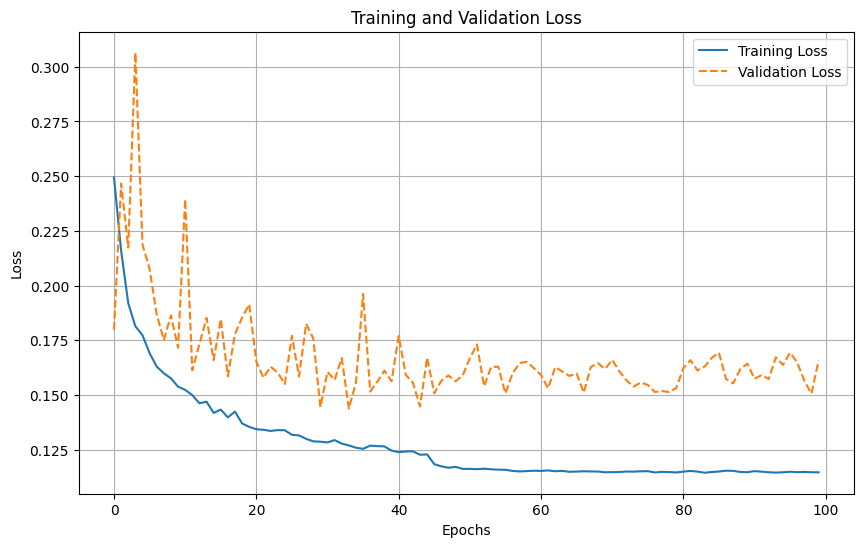

In [18]:
# Retrieve the training and validation losses from CAREamist
losses = careamist.get_losses()

# Extract train and validation losses and epochs with defaults
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = losses.get('train.epoch', list(range(len(train_losses))))
val_epochs = losses.get('val.epoch', list(range(len(val_losses))))

plt.figure(figsize=(10, 6))

if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
else:
    print("No training data found.")

if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')
else:
    print("No validation data found.")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


## And you're done! Let's create a cover 

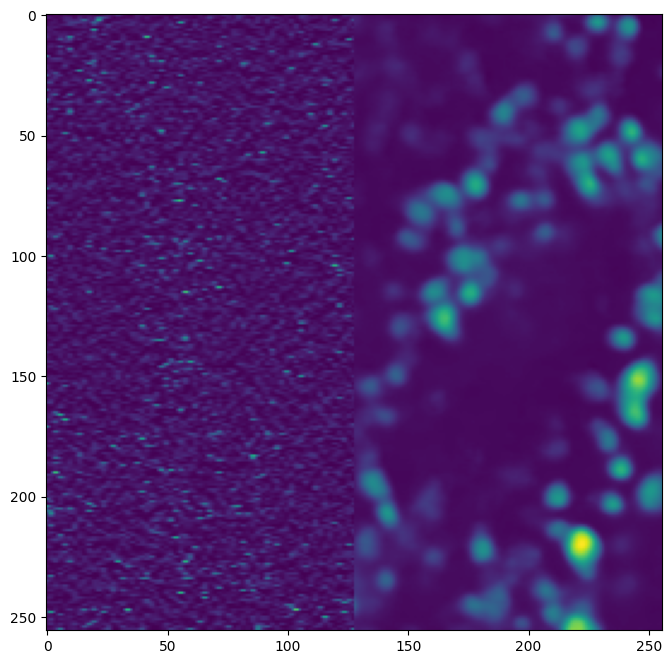

In [49]:
slice_idx = 31

# Extract slices
low_img = test_low_images[slice_idx]
pred_img = test_predictions[slice_idx]

# Create a square image
size = 256
x_start = (low_img.shape[1] - size) // 2
y_start = (low_img.shape[0] - size) // 2

# Create image canvas
cover = np.zeros((size, size))

# Normalize images for better visualization
norm_low = (low_img - low_img.min()) / (low_img.max() - low_img.min())
norm_pred = (pred_img - pred_img.min()) / (pred_img.max() - pred_img.min())

# Fill in halves
cover[:, :size//2] = norm_low[y_start:y_start+size, x_start:x_start+size//2]
cover[:, size//2:] = norm_pred[y_start:y_start+size, x_start+size//2:x_start+size]

# Plot with axis
plt.figure(figsize=(8, 8))
plt.imshow(cover, cmap="viridis")
plt.savefig("Tribolium_CARE_cover.jpg", dpi=300, bbox_inches='tight')

# Save raw image
from PIL import Image
im = Image.fromarray((cover * 255).astype(np.uint8))
im = im.convert("L")
im.save("Tribolium_CARE.jpeg")

In [52]:
# Export the model to BMZ format
general_description = """
This model is trained using the CARE algorithm to denoise Tribolium castaneum images. 
The training data consists of nuclei-labeled EFA::nGFP transgenic line embryos imaged with 
fluorescence microscopy at different intensities. The notebook used to train this model is 
available on the CAREamics documentation website.
"""
careamist.export_to_bmz(
    path_to_archive="tribolium_care_model.zip",
    friendly_model_name="Tribolium_CARE",
    input_array=test_low_images[slice_idx:slice_idx+8, y_start:y_start+size, x_start:x_start+size].astype(np.float32),
    authors=[{"name": "CAREamics authors", "affiliation": "Your Institution"}],
    general_description=general_description,
    data_description="Tribolium castaneum embryo nuclei labeled with EFA::nGFP"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

computing SHA256 of inputs.npy (result: ac41d09b5ecb6829c9be9a0ed218acfa737dcf680b8f1719edfb392d442e8715): 100%|██████████| 2097280/2097280 [00:00<00:00, 709920901.71it/s] 
computing SHA256 of outputs.npy (result: 5a7f5547e27b559c12c3ee7e4618e2287e076f662f525a24e4448c3c4f2fefdd): 100%|██████████| 2097280/2097280 [00:00<00:00, 585505184.58it/s]
computing SHA256 of environment.yml (result: fcb28a47de772ad4152cc36bed5c7166c0e67bcf50462610439fe1816b84d075): 100%|██████████| 157/157 [00:00<00:00, 91982.92it/s] 
computing SHA256 of weights.pth (result: 4613ebce23e665cb8ec2c753ba8d176fe0a98ae104dfec08fa9b98cb8f6adefd): 100%|██████████| 6124158/6124158 [00:00<00:00, 857906562.77it/s] 
computing SHA256 of careamics.yaml (result: 61b06136f4bd2a85557c4709dee500f080126d6c3b356ef477448926ee734666): 100%|██████████| 1133/1133 [00:00<00:00, 615642.76it/s] 
2025-02-25 12:06:11.327 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found